In [2]:
pip freeze > model_requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#data_train_df = pd.read_csv("data_train_csv")

#data_train_df = pd.read_csv("data_train_smote_auto_csv")

data_train_df = pd.read_csv("data_train_smote_min_csv")

data_test_df = pd.read_csv("data_test_csv")

In [5]:
data_train_df

,Unnamed: 0,Wickets taken,Remaining Team Value,Remaining Average Team Value,Start Team Value,Ground RPO,Ground RPW,Remaining overs and balls,Remainder,Winner_num
0,0,3,16,2.000000,24,4.79,29.31,179,29.500000,1
1,1,3,16,2.000000,24,4.79,29.31,178,29.400000,1
2,2,3,16,2.000000,24,4.79,29.31,176,29.200000,1
3,3,3,16,2.000000,24,4.79,29.31,175,29.100000,1
4,4,3,16,2.000000,24,4.79,29.31,173,28.500000,1
...,...,...,...,...,...,...,...,...,...,...
323253,323253,2,19,2.111111,24,5.07,31.45,152,25.295248,2
323254,323254,3,17,2.125000,25,5.01,32.44,100,16.437651,2
323255,323255,6,9,1.800000,24,5.01,31.44,21,3.338931,2
323256,323256,5,10,1.666667,22,4.19,22.99,70,11.401138,2


In [7]:
data_train_df = data_train_df.drop(['Unnamed: 0'], axis=1)
data_test_df = data_test_df.drop(['Unnamed: 0'], axis=1)

In [8]:
#data_train_df = data_train_df.drop(['Unnamed: 0', 'Row ID', 'Start Team Value', 'Ground RPO', 'Remaining Average Team Value', 'Remaining overs and balls'], axis=1)
#data_test_df = data_test_df.drop(['Unnamed: 0', 'Row ID', 'Start Team Value', 'Ground RPO', 'Remaining Average Team Value', 'Remaining overs and balls'], axis=1)

In [9]:
#data_train_df = data_train_df.drop(['Start Team Value', 'Remaining overs and balls', 'Remaining Average Team Value', 'Ground RPO'], axis=1)
#data_test_df = data_test_df.drop(['Start Team Value', 'Remaining overs and balls', 'Remaining Average Team Value', 'Ground RPO'], axis=1)

y_train = data_train_df['Winner_num']
X_train = data_train_df.drop('Winner_num',axis=1)
X_test = data_test_df.drop('Winner_num',axis=1) 
y_test = data_test_df['Winner_num']

In [10]:
#y_train = data_train_df['Winner_num']
#X_train = data_train_df.drop('Winner_num',axis=1)
#X_test = data_test_df.drop('Winner_num',axis=1)
#y_test = data_test_df['Winner_num']

In [11]:
data_train_df

,Wickets taken,Remaining Team Value,Remaining Average Team Value,Start Team Value,Ground RPO,Ground RPW,Remaining overs and balls,Remainder,Winner_num
0,3,16,2.000000,24,4.79,29.31,179,29.500000,1
1,3,16,2.000000,24,4.79,29.31,178,29.400000,1
2,3,16,2.000000,24,4.79,29.31,176,29.200000,1
3,3,16,2.000000,24,4.79,29.31,175,29.100000,1
4,3,16,2.000000,24,4.79,29.31,173,28.500000,1
...,...,...,...,...,...,...,...,...,...
323253,2,19,2.111111,24,5.07,31.45,152,25.295248,2
323254,3,17,2.125000,25,5.01,32.44,100,16.437651,2
323255,6,9,1.800000,24,5.01,31.44,21,3.338931,2
323256,5,10,1.666667,22,4.19,22.99,70,11.401138,2


Random Forest model

In [12]:
X_train

,Wickets taken,Remaining Team Value,Remaining Average Team Value,Start Team Value,Ground RPO,Ground RPW,Remaining overs and balls,Remainder
0,3,16,2.000000,24,4.79,29.31,179,29.500000
1,3,16,2.000000,24,4.79,29.31,178,29.400000
2,3,16,2.000000,24,4.79,29.31,176,29.200000
3,3,16,2.000000,24,4.79,29.31,175,29.100000
4,3,16,2.000000,24,4.79,29.31,173,28.500000
...,...,...,...,...,...,...,...,...
323253,2,19,2.111111,24,5.07,31.45,152,25.295248
323254,3,17,2.125000,25,5.01,32.44,100,16.437651
323255,6,9,1.800000,24,5.01,31.44,21,3.338931
323256,5,10,1.666667,22,4.19,22.99,70,11.401138


In [13]:
X_test

,Wickets taken,Remaining Team Value,Remaining Average Team Value,Start Team Value,Ground RPO,Ground RPW,Remaining overs and balls,Remainder
0,3,16,2.000000,24,4.79,29.31,177,29.3
1,3,16,2.000000,24,4.79,29.31,174,29.0
2,3,16,2.000000,24,4.79,29.31,167,27.5
3,3,16,2.000000,24,4.79,29.31,163,27.1
4,3,16,2.000000,24,4.79,29.31,156,26.0
...,...,...,...,...,...,...,...,...
54040,2,16,1.777778,21,5.40,31.64,38,6.2
54041,2,16,1.777778,21,5.40,31.64,36,6.0
54042,3,13,1.625000,21,5.40,31.64,29,4.5
54043,3,13,1.625000,21,5.40,31.64,19,3.1


Train the baseline RF classifier

In [14]:
rnd_clf = RandomForestClassifier(random_state=7)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=7)

In [15]:
rnd_clf_train_score = rnd_clf.score(X_train, y_train)
rnd_clf_test_score = rnd_clf.score(X_test, y_test)
print("Training score:", rnd_clf_train_score)
print("Testing score:", rnd_clf_test_score)

Training score: 0.9780144652259186
Testing score: 0.9309279304283468


In [16]:
y_pred_rf = rnd_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf, labels=rnd_clf.classes_)
cm_norm = confusion_matrix(y_test, y_pred_rf, labels=rnd_clf.classes_, normalize='true')
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '2', '3'])

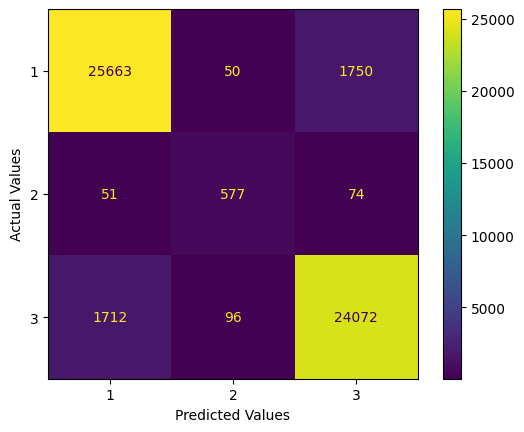

In [17]:
cmd.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

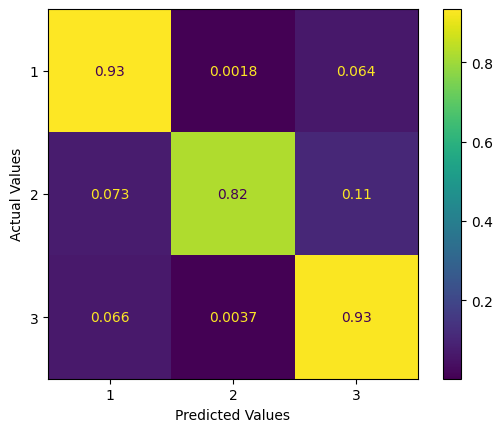

In [18]:
cmd_norm = ConfusionMatrixDisplay(confusion_matrix = cm_norm, display_labels=['1', '2', '3'])
cmd_norm.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [19]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           1       0.94      0.93      0.94     27463
           2       0.80      0.82      0.81       702
           3       0.93      0.93      0.93     25880

    accuracy                           0.93     54045
   macro avg       0.89      0.90      0.89     54045
weighted avg       0.93      0.93      0.93     54045



Tune the RF model

In [20]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, train_test_split


param_dist = {'max_depth': randint(1,20),
              #guessing at min sample split
              'min_samples_split': randint(2,10),
              #'max_leaf_nodes': randint(),
              #guess for min samples leaf
              'min_samples_leaf': randint(1,500),
              'n_estimators': randint(50,500),
              #'max_sample': randint(),
              'max_features': randint(1,8)
              }

# Create a random forest classifier
rf = RandomForestClassifier(random_state=7)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=8, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

In [ ]:
sdfhjk

Use the tuned hyperparameters for a new RF

In [ ]:
rnd_clf_tweaked = RandomForestClassifier(n_estimators=211, max_depth=16, min_samples_split=7, min_samples_leaf=227, max_features=4, 
                                 n_jobs=-1, random_state=7)
rnd_clf_tweaked.fit(X_train, y_train)

In [ ]:
rnd_clf_tweaked_train_score = rnd_clf_tweaked.score(X_train, y_train)
rnd_clf_tweaked_test_score = rnd_clf_tweaked.score(X_test, y_test)
print("Training score:", rnd_clf_tweaked_train_score)
print("Testing score:", rnd_clf_tweaked_test_score )

In [ ]:
y_tweaked_pred_rf = rnd_clf_tweaked.predict(X_test)

cm = confusion_matrix(y_test, y_tweaked_pred_rf, labels=rnd_clf_tweaked.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['1', '2', '3'])
cmd.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
cm_norm = confusion_matrix(y_test, y_tweaked_pred_rf, labels=rnd_clf_tweaked.classes_, normalize='true')
cmd_norm = ConfusionMatrixDisplay(confusion_matrix = cm_norm, display_labels=['1', '2', '3'])
cmd_norm.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print(classification_report(y_test, y_pred_rf))

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [ ]:
sdfasdf

https://www.datacamp.com/tutorial/random-forests-classifier-python

LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)

X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

explained_variance = lda.explained_variance_ratio_

print(explained_variance)

In [ ]:
n_component_1 = 0.99099846
n_component_2 = 0.00900154
percentage_of_variance_explained = n_component_1 + n_component_2
print("Percentage of variance explained = " + str(percentage_of_variance_explained*100))

In [ ]:
classifier_lda = RandomForestClassifier(max_depth=11, random_state=7)

classifier_lda.fit(X_train_lda, y_train)
y_pred_lda = classifier_lda.predict(X_test_lda)

print('Confusion matrix : \n' + str(confusion_matrix(y_test, y_pred_lda)))
print('Accuracy score : \n' + str(accuracy_score(y_test, y_pred_lda)))

In [ ]:
X_train_lda.shape

In [ ]:
X_train_lda = pd.DataFrame(X_train_lda)

In [ ]:
X_train_lda.columns=['LDA 1', 'LDA 2']

In [ ]:
X_train_lda

In [ ]:
X_train['LDA 1']= X_train_lda['LDA 1']
X_train['LDA 2']= X_train_lda['LDA 2']

In [ ]:
X_train

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, train_test_split


param_dist = {'max_depth': randint(1,20),
              #guessing at min sample split
              'min_samples_split': randint(2,10),
              #'max_leaf_nodes': randint(),
              #guess for min samples leaf
              'min_samples_leaf': randint(1,500),
              'n_estimators': randint(50,500),
              #'max_sample': randint(),
              'max_features': randint(1,10)
              }

# Create a random forest classifier
rf = RandomForestClassifier(random_state=7)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=8, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

In [ ]:
asjdflkjsdflk

In [ ]:
rnd_clf_tweaked = RandomForestClassifier(n_estimators=156, max_depth=19, min_samples_split=5, min_samples_leaf=234, max_features=2, 
                                 n_jobs=-1, random_state=7)
rnd_clf_tweaked.fit(X_train, y_train)

In [ ]:
rnd_clf_tweaked_train_score = rnd_clf_tweaked.score(X_train, y_train)
rnd_clf_tweaked_test_score = rnd_clf_tweaked.score(X_test, y_test)
print("Training score:", rnd_clf_tweaked_train_score)
print("Testing score:", rnd_clf_tweaked_test_score )

In [ ]:
X_test